In [11]:
import torch 
import torchvision 
print(f"torch version : {torch.__version__}")
print(f"torchvision version : {torchvision.__version__}")

torch version : 2.2.2
torchvision version : 0.17.2


In [12]:
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

#from torchinfo import summary 
import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [15]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [16]:
# Create image size (from Table 3 in ViT paper)
IMG_SIZE = 224

#Create transform pipeline manually 
manual_transforms = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                        transforms.ToTensor(),
                                        ])

print(f"Manually created transforms: {manual_transforms}")


Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [17]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x15f222810>,
 ['pizza', 'steak', 'sushi'])

In [18]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

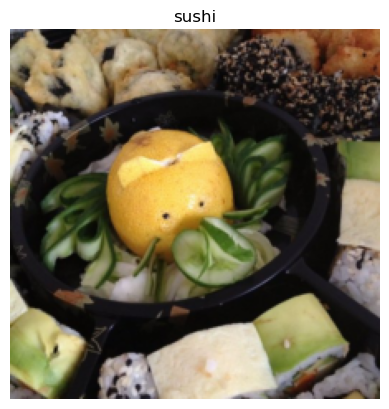

In [19]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [20]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [21]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


In [22]:
# Creating patches of the image 

patch_size = 16 

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding = 0)



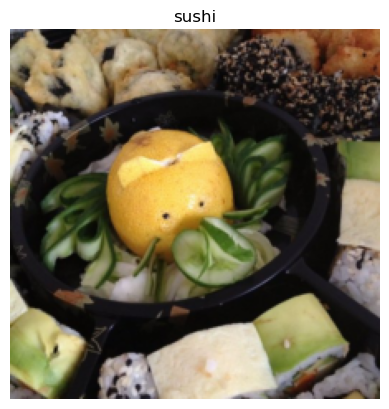

In [23]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [24]:
# Pass the image through the convolutional layer 
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [525, 163, 660, 57, 294]


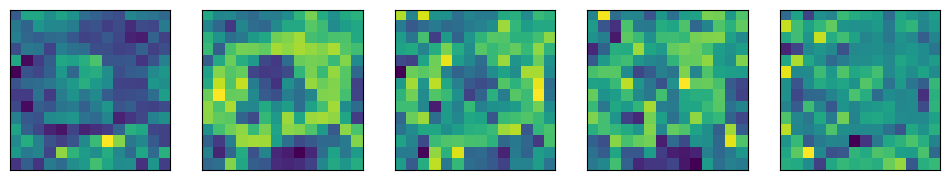

In [25]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [26]:
# Flattern the feature maps only, not the entire tensor
# Create a flatten layer 

flatten = nn.Flatten(start_dim=2,
                     end_dim=3)


Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


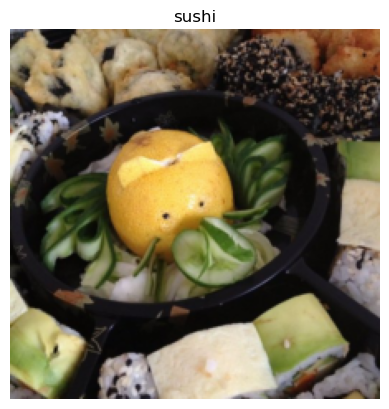

In [27]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [28]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


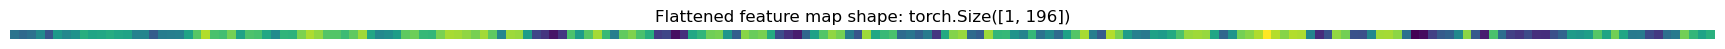

In [29]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [30]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-3.7561e-01, -4.0804e-01, -3.8345e-01, -3.0349e-01, -4.6490e-01,
          -2.5826e-01, -3.1098e-01, -2.8040e-01, -1.8844e-01, -2.1867e-01,
          -2.1156e-01, -1.9462e-01, -2.1619e-01, -2.2543e-01, -3.2892e-01,
          -3.2158e-01, -4.4692e-01, -3.4725e-01, -3.4196e-01, -3.3560e-01,
          -2.2492e-01, -1.0249e-01,  6.6714e-03, -1.2269e-01, -1.3700e-01,
          -6.5807e-02, -2.2961e-01, -1.1784e-01, -1.2586e-01, -2.1246e-01,
          -2.9966e-01, -1.6773e-01, -1.7598e-01, -5.6863e-02,  9.0503e-05,
          -2.9044e-02, -1.0764e-01, -1.0875e-01, -1.4626e-01, -9.2094e-02,
          -1.3684e-02, -2.1682e-01, -3.1222e-01, -2.9109e-01, -2.4306e-01,
          -9.4911e-02, -7.2963e-02, -1.5689e-01, -1.6224e-01, -5.9427e-02,
          -5.8636e-03, -9.5387e-03, -3.1877e-02, -6.2617e-02, -9.5509e-03,
          -9.3147e-02, -3.1735e-01, -1.5894e-02, -2.1299e-02, -2.4272e-01,
          -5.0536e-01, -5.5147e-01, -6.2616e-01, -5.4332e-01, -1.2195e-01,
          -2.4539e-01, -1

In [31]:
# We've turned our single 2D image into a 1D learnable embedding vector (or "Linear Projection of Flattned Patches" in Figure 1 of the ViT paper).

In [32]:
# Creating a PyTorch Layer for patch embedding 

class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """

    def __init__(self, in_channels:int =3, 
                 patch_size: int = 16,
                 embedding_dim: int = 768):
        super().__init__()

        #Create a layer to turn image into patches 

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding = 0)
        
        # Create a layer to flatten the patch feature maps into a single dimension 

        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
        
    
    # Define the forward method 
    
    def forward(self, x):
        #Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1)
    

# End of class 

In [33]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [34]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[ 0.5436, -0.4700, -1.2133,  0.8982,  1.3769,  0.4988, -0.5628,
           0.2139,  0.5812, -1.1086]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [35]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 0.5436, -0.4700, -1.2133,  ..., -0.4571,  0.4486,  0.1217],
         [-0.5792,  0.2310, -0.1614,  ...,  0.5000, -0.2277,  0.0662],
         [-0.1782, -0.1001, -0.3104,  ...,  0.1352, -0.1440,  0.4665],
         ...,
         [-0.1430,  0.1066, -0.3623,  ...,  0.3648, -0.1727,  0.0578],
         [-0.6525,  0.1065, -0.0020,  ...,  0.2624, -0.2251,  0.1266],
         [-0.3967,  0.1182, -0.1489,  ...,  0.4059, -0.2915,  0.1469]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [36]:
# Adding the position embedding 

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.randn(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-1.0264, -2.4631,  0.1703, -0.3792, -0.2175,  0.3899, -1.8656,
          -0.0395,  0.3717,  0.1368],
         [-0.6950,  0.7188, -1.1410, -0.5563,  0.3425, -0.7327, -0.0052,
          -0.8103, -0.7187, -0.1611],
         [-1.5855, -0.3176, -1.4012, -1.3915, -0.1853,  0.6562,  0.5200,
           0.0703,  0.2820,  0.9959],
         [-0.3998, -0.2792, -0.3343, -0.3861,  0.9294, -0.0130, -0.1827,
          -0.6484,  1.7424, -0.8374],
         [-0.5009,  1.0029,  0.7872,  0.1788, -0.4658,  0.4155,  0.2546,
          -0.0953,  0.1655, -1.2776],
         [ 1.6989,  0.4772,  0.1792, -0.2499, -1.0494, -0.4248,  1.1466,
          -1.3408,  1.0880, -0.4174],
         [-0.1335,  0.9364,  0.5888,  0.9429, -0.4862, -0.1939,  0.7016,
           0.3350,  0.2557,  0.2404],
         [-0.4736, -1.2536,  1.6649,  0.1761,  0.0667, -1.2113, -0.3906,
           0.5781, -0.6048, -0.3013],
         [ 0.6837, -0.4015, -1.0961, -3.0875, -0.3553,  0.6072, -0.3472,
           1.8270, -0.3787, -0.2578],
 

In [37]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-4.8279e-01, -2.9331e+00, -1.0430e+00,  ..., -3.1039e-01,
           1.8254e+00,  7.0189e-01],
         [-1.2742e+00,  9.4984e-01, -1.3023e+00,  ...,  1.8473e-01,
          -2.4498e+00, -6.2602e-01],
         [-1.7636e+00, -4.1767e-01, -1.7116e+00,  ...,  1.9334e+00,
           3.6375e-01,  4.9799e-01],
         ...,
         [ 1.1425e+00,  9.3687e-01, -2.1269e-01,  ..., -1.1032e-01,
           1.0937e+00,  7.3356e-01],
         [-6.9313e-01, -4.1056e-01, -3.5085e-01,  ..., -2.2975e-01,
           1.2515e-01,  1.4737e+00],
         [-6.4210e-01,  1.1347e-01,  1.3495e+00,  ..., -1.5796e-03,
           1.2870e+00, -1.8114e-01]]], grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [38]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [39]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [40]:
class MLPBlock(nn.Module):
    """ Creates a layer normalized multi-layer perceptron block """

    def __init__(self, 
                 embedding_dim : int = 768,
                 mlp_size: int = 3072,
                 dropout: float = 0.1):
        super().__init__()

        # Create a LN layer 
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the MLP 
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p = dropout)          
        )
    
    def forward(self, x):
        # Create a forward method to pass the data through the layers 
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x



In [41]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [42]:
class TransformerEncoderBlock(nn.Module):
    """ Creates a Transformer Encoder Block """

    def __init__(self, 
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 mlp_size : int = 3072,
                 mlp_dropout: float = 0.1,
                 attn_dropout: float = 0):
        super().__init__()

        # Create MSA Block
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads= num_heads,
                                                     attn_dropout=attn_dropout
                                                     )
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa_block(x) + x

        x = self.mlp_block(x) + x

        return x

In [43]:
class ViT(nn.Module):
    """ Creates a Vision Transformer architecture with ViT-Base hyperparameters by default"""

    def __init__(self,
                 img_size: int = 224,
                 in_channels: int = 3,
                 patch_size: int = 16,
                 num_transformer_layers: int = 12,
                 embedding_dim: int = 768,
                 mlp_size : int = 3072,
                 num_heads: int = 12,
                 attn_dropout: float = 0,
                 mlp_dropout: float = 0.1,
                 embedding_dropout: float = 0.1,
                 num_classes: int = 1000 # Default for ImageNet but can be customised
                 ):
        super().__init__()

        assert img_size%patch_size == 0, f"Image size must be divisible by patch size"

        # Calculate number of patches = (height * width / patch^2)
        self.num_patches = (img_size * img_size)//patch_size**2

        # Create a learnable class embedding - goes at the front of the sequence of patch embeddings 
        self.class_embedding = nn.Parameter(data = torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # Create a learnable positional embedding 
        self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
        
        # Create embedding dropout value 
        self.embedding_droput = nn.Dropout(p = embedding_dropout)

        # Create a patch embedding layer 
        self.patch_embedding_layer = PatchEmbedding(in_channels=in_channels,
                                                    patch_size=patch_size,
                                                    embedding_dim=embedding_dim)
        
        # Create tranformer encoder blocks - making a stack 
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        
        # Create a classifier head 
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
    

    def forward(self, x):
        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding_layer(x)

        x = torch.cat((class_token,x), dim=1)

        x = self.position_embedding + x

        x = self.embedding_droput(x)

        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0])

        return x

In [44]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[0.2525, 0.8748, 1.2374]], grad_fn=<AddmmBackward0>)

In [45]:
import engine 

In [ ]:
# Setup optimizer for the ViT model
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr = 3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds 
set_seeds()

# Train the model and save the training results to a directory 
resutls = engine.train(model=vit,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 10,
                       device = device)

In [ ]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)